In [85]:
import jax.numpy as jnp
import jax 
from jax import lax 
from jax import jit
from jaxtyping import Array, Float
from jraph import GraphsTuple
from collections.abc import Callable
from typing import Union, Optional
from typing import Protocol, Tuple


from jax.tree_util import register_pytree_node_class


@register_pytree_node_class
class Cochain:
    """
    A k-cochain on a graph: a function on k-simplices.
    For graphs: 
      k = 0 → node function,
      k = 1 → edge function
    """

    def __init__(self, graph: GraphsTuple, k: int, coeffs: Optional[Float[Array, "N"]] = None):
        self.k = k
        self.graph = graph
        num_simplices = graph.nodes.shape[0] if k == 0 else graph.edges.shape[0]

        if coeffs is not None:
            self.coeffs = coeffs
        else:
            self.coeffs = jnp.zeros(num_simplices)

    def __mul__(self, other: Union[float, "Cochain"]) -> "Cochain":
        """Element-wise product for cochains of same degree on the same graph."""
        if jnp.isscalar(other):
            return Cochain(self.graph, self.k, self.coeffs * other)
        if isinstance(other, Cochain):
            assert self.k == other.k, "Cochains must have the same degree."
            assert self.graph == other.graph, "Cochains must be defined on the same graph."
            return Cochain(self.graph, self.k, self.coeffs * other.coeffs)
        raise ValueError("Unsupported type for multiplication.")    

    def __div__(self, other: Union[float, "Cochain"]) -> "Cochain":
        """Element-wise division for cochains of same degree on the same graph."""
        if jnp.isscalar(other):
            return Cochain(self.graph, self.k, self.coeffs / other)
        if isinstance(other, Cochain):
            assert self.k == other.k, "Cochains must have the same degree."
            assert self.graph == other.graph, "Cochains must be defined on the same graph."
            return Cochain(self.graph, self.k, self.coeffs / other.coeffs)
        raise ValueError("Unsupported type for division.")
    
    def __rmul__(self, other: Union[float, jnp.ndarray]) -> "Cochain":
        return self.__mul__(other)

    def __add__(self, other: "Cochain") -> "Cochain":
        """Element-wise addition for cochains of same degree on the same graph."""
        assert self.k == other.k, "Cochains must have the same degree."
        assert self.graph == other.graph, "Cochains must be defined on the same graph."
        return Cochain(self.graph, self.k, self.coeffs + other.coeffs)

    def __repr__(self):
        return f"Cochain(degree={self.k})"
    
    def tree_flatten(self):
        children = (self.coeffs,)
        aux_data = (self.graph, self.k)
        return children, aux_data

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        graph, k = aux_data
        coeffs, = children
        return cls(graph, k, coeffs)


def coboundary_adjoint(c: Cochain) -> Cochain:
    r"""
    Implements δ*: 1-cochain → 0-cochain (divergence operator).
    Only supports 1-cochains on edges → 0-cochain on nodes.
    """
    assert c.k == 1, "Coboundary adjoint currently only supports 1-cochains."

    senders = c.graph.senders
    receivers = c.graph.receivers
    num_nodes = c.graph.nodes.shape[0]

    div = jnp.zeros((num_nodes,))
    div = div.at[senders].add(-c.coeffs)   # outflow
    div = div.at[receivers].add(c.coeffs)  # inflow

    return Cochain(c.graph, k=0, coeffs=div)


def coboundary(c: Cochain) -> Cochain:
    r"""
    Implements the coboundary operator δ: 0-cochain → 1-cochain.

    For an edge [i → j], δf([i, j]) = f(j) - f(i),
    where f is the 0-cochain (node scalar field).
    """
    assert c.k == 0, "Coboundary operator δ only defined for 0-cochains (nodes → edges)."

    graph = c.graph
    senders = graph.senders
    receivers = graph.receivers

    # Compute δf([i, j]) = f(j) - f(i)
    edge_vals = c.coeffs[receivers] - c.coeffs[senders]

    return Cochain(graph, k=1, coeffs=edge_vals)


def continuity_equation_euler_step(p: Cochain, nu: Cochain, dt: float) -> Cochain:
    r"""
    Simulates one step: p + dt * δ*(nu(p))
    """
    assert p.k == 0, "p must be a 0-cochain (node values)."
    assert nu.k == 1, "omega must be a 1-cochain (edge flows)."
    assert p.graph == nu.graph, "Both cochains must be defined on the same graph."

    div_flow = coboundary_adjoint(flow_field(p, nu))
    return p + dt * div_flow


def codegree(graph: GraphsTuple, k: int) -> jnp.ndarray:
    """
    Compute the codegree of k-simplices in a graph.

    Currently supports:
        - k = 0: node codegree = number of outgoing edges from each node

    Returns:
        jnp.ndarray of shape (num_k_cells,) containing the codegree.
    """
    assert k == 0, "Codegree currently only implemented for 0-cochains (nodes)."

    num_nodes = graph.nodes.shape[0]
    senders = graph.senders
    return jnp.zeros(num_nodes).at[senders].add(1)


def lift(p: Cochain) -> Cochain:
    r"""
    Lifts a 0-cochain to a 1-cochain via:

        \hat{L}(p)([v0, v1]) = p(v0)

    where [v0, v1] is an oriented edge.
    """
    assert p.k == 0, "lift only supports lifting from 0- to 1-cochains."

    graph = p.graph
    senders = graph.senders
    lifted_vals = p.coeffs[senders]

    return Cochain(graph, k=1, coeffs=lifted_vals)


def mass_preserving_lift(p: Cochain) -> Cochain:
    r"""
    Lifts a 0-cochain to a 1-cochain while preserving mass via:

        \hat{L}(p)([v0, v1]) = p(v0) / codeg(v0)

    where codeg(v0) counts outgoing edges only (oriented).
    """
    assert p.k == 0, "mass_preserving_lift only supports lifting from 0- to 1-cochains."

    graph = p.graph
    cdeg = codegree(graph, k=0)

    senders = graph.senders
    lifted_vals = p.coeffs[senders] / cdeg[senders]

    return Cochain(graph, k=1, coeffs=lifted_vals)


def flow_field(p: Cochain, nu: Cochain) -> Cochain:
    assert p.k + 1 == nu.k, "p and nu must be cochains of consecutive degrees."
    return mass_preserving_lift(p) * nu


def simulate_continuity_equation(p: Cochain, nu: Callable[[float], Cochain], num_steps: int = 1000) -> Cochain:
    """
    Simulates the continuity equation from t=0 to t=1 using Euler method.
    """
    dt = 1.0 / num_steps

    def step_fn(i, p_curr):
        t = i * dt
        nu_t = nu(t)
        return continuity_equation_euler_step(p_curr, nu_t, dt)

    p_final = lax.fori_loop(0, num_steps, step_fn, p)
    return p_final


def simulate_continuity_equation_trajectory(
    p0: Cochain,
    nu_fn: Callable[[float], Cochain],
    num_steps: int = 1000
) -> list[Cochain]:
    """
    Simulates the continuity equation from t=0 to t=1 using Euler method.
    Returns a list of all intermediate p_t states.
    """
    dt = 1.0 / num_steps

    def step_fn(p_curr, i):
        t = i * dt
        nu_t = nu_fn(t)
        p_next = continuity_equation_euler_step(p_curr, nu_t, dt)
        return p_next, (p_next,)  # Note the tuple with trailing comma

    # Run scan to collect trajectory
    _, trajectory = lax.scan(step_fn, p0, jnp.arange(num_steps))

    # trajectory is a tuple of Cochains → unpack it
    return [p0] + list(trajectory)


"""
==================================== BIHARMONIC DISTANCE ====================================
"""
def graph_laplacian(graph: GraphsTuple) -> Float[Array, "N N"]:
    """
    Constructs the (combinatorial) Laplacian L = D - A
    for an undirected graph with fixed orientation (v < w).
    The Laplacian is symmetric and ignores orientation.
    """
    num_nodes = graph.nodes.shape[0]
    senders = graph.senders
    receivers = graph.receivers

    # Construct adjacency matrix A (symmetric)
    A = jnp.zeros((num_nodes, num_nodes))
    A = A.at[senders, receivers].set(1.0)
    A = A.at[receivers, senders].set(1.0)  # symmetry from undirected assumption

    # Degree matrix D
    degree = jnp.sum(A, axis=1)
    D = jnp.diag(degree)

    # Laplacian
    L = D - A
    return L


def laplacian_eigenpairs(graph: GraphsTuple) -> tuple[Float[Array, "N"], Float[Array, "N N"]]:
    """
    Computes the eigenvalues and eigenvectors of the graph Laplacian.

    Returns:
        (eigenvalues, eigenvectors), where:
          - eigenvalues: shape (n,)
          - eigenvectors: shape (n, n) with columns as orthonormal eigenvectors
    """
    L = graph_laplacian(graph)
    eigvals, eigvecs = jnp.linalg.eigh(L)  # symmetric Laplacian => use eigh
    return eigvals, eigvecs



class Premetric(Protocol):
    def distance(self, x: int, y: int) -> float:
        """Return the premetric (not necessarily satisfying triangle inequality)"""
        ...

    def __call__(self, x: int, y: int) -> float:
        """Return the premetric (not necessarily satisfying triangle inequality)"""
        ...

    def conditional_distance(self, tau: int) -> Cochain:
        """Return the conditional distance from node tau to all other nodes."""
        ...


class BiharmonicDistance(Premetric):
    def __init__(self, graph: GraphsTuple):
        """
        Args:
            eigenpairs: (eigvals, eigvecs), where
              - eigvals: shape (n,)
              - eigvecs: shape (n, n), with columns as eigenvectors
        """
        self.graph = graph
        eigvals, eigvecs = laplacian_eigenpairs(self.graph)

        # Remove the first eigenpair (zero eigenvalue)
        self.eigvals = eigvals[1:]
        self.eigvecs = eigvecs[:, 1:]

    def distance(self, x: int, y: int) -> float:
        """
        Computes the squared biharmonic distance between nodes x and y:
            d(x, y)^2 = sum_i (φ_i(x) - φ_i(y))^2 / λ_i^2
        """
        phi_x = self.eigvecs[x]
        phi_y = self.eigvecs[y]
        diff_sq = (phi_x - phi_y) ** 2
        return jnp.sum(diff_sq / self.eigvals**2)

    def __call__(self, x: int, y: int) -> float:
        return self.distance(x, y)
    
    def conditional_distance(self, tau: int) -> Cochain:
        """
        Computes the conditional distance from node x to all other nodes.
        """
        phi_x = self.eigvecs[tau]
        diff_sq = (self.eigvecs - phi_x) ** 2
        return Cochain(self.graph, k=0, coeffs=jnp.sum(diff_sq / self.eigvals**2, axis=1))

"""
==================================== CONDITIONAL FLOW FIELD ====================================
"""

def linear_schedule(t: float) -> float:
    return 1 - t


def conditional_flow_field(tau: int, rho: Premetric, t: float) -> Cochain:
    rho_tau = rho.conditional_distance(tau)
    drho_tau = coboundary(rho_tau)
    dkappa = jax.jacfwd(linear_schedule)(t)

    cochain = lift(rho_tau) * drho_tau
    return dkappa * cochain


def uniform_distribution(graph: GraphsTuple) -> Cochain:
    """
    Initializes a uniform distribution over the nodes of the graph.
    """
    num_nodes = graph.nodes.shape[0]
    uniform_coeffs = jnp.ones(num_nodes) / num_nodes
    return Cochain(graph, k=0, coeffs=uniform_coeffs)

In [91]:
import networkx as nx
import matplotlib.pyplot as plt
import jraph
import jax.numpy as jnp
import numpy as np


def build_circle_graph(n: int) -> GraphsTuple:
    """
    Builds a circle (ring) graph with `n` nodes.
    Each node i is connected to (i+1) mod n.
    """
    import jraph
    import jax.numpy as jnp

    # Construct edges for the ring
    senders = jnp.arange(n)
    receivers = (senders + 1) % n  # wrap around

    # For undirected graphs, add symmetric edges
    senders = jnp.concatenate([senders, receivers])
    receivers = jnp.concatenate([receivers, senders[:n]])

    # Dummy features
    nodes = jnp.ones((n, 1))
    edges_feat = jnp.ones((len(senders), 1))

    return jraph.GraphsTuple(
        nodes=nodes,
        edges=edges_feat,
        senders=senders,
        receivers=receivers,
        n_node=jnp.array([n]),
        n_edge=jnp.array([len(senders)]),
        globals=None
    )


def build_karate_graph() -> GraphsTuple:
    G = nx.karate_club_graph()

    num_nodes = G.number_of_nodes()
    edges = list(G.edges())
    senders = jnp.array([u for u, v in edges])
    receivers = jnp.array([v for u, v in edges])

    # Dummy features (unused but required by jraph)
    nodes = jnp.ones((num_nodes, 1))
    edges_feat = jnp.ones((len(edges), 1))

    return jraph.GraphsTuple(
        nodes=nodes,
        edges=edges_feat,
        senders=senders,
        receivers=receivers,
        n_node=jnp.array([num_nodes]),
        n_edge=jnp.array([len(edges)]),
        globals=None
    )


def build_example_graph() -> GraphsTuple:
    """
    Constructs a small example undirected graph:
    - Triangle between nodes 0-1-2
    - Line from node 2-3-4
    """
    edges = jnp.array([
        [0, 1],
        [1, 2],
        [2, 0],
        [2, 3],
        [3, 4]
    ])

    num_nodes = 5
    senders = edges[:, 0]
    receivers = edges[:, 1]

    # Dummy node and edge features
    nodes = jnp.ones((num_nodes, 1))
    edges_feat = jnp.ones((edges.shape[0], 1))

    return jraph.GraphsTuple(
        nodes=nodes,
        edges=edges_feat,
        senders=senders,
        receivers=receivers,
        n_node=jnp.array([num_nodes]),
        n_edge=jnp.array([edges.shape[0]]),
        globals=None,
    )

def plot_graph(graph: GraphsTuple):
    G = nx.Graph()
    for i in range(graph.nodes.shape[0]):
        G.add_node(i)
    for s, r in zip(graph.senders, graph.receivers):
        G.add_edge(int(s), int(r))

    pos = nx.spring_layout(G, seed=42)  # deterministic layout
    nx.draw(G, pos, with_labels=True, node_color="skyblue", edge_color="gray", node_size=600)
    plt.title("Example Graph")
    plt.show()



def plot_laplacian_eigenvectors(graph: GraphsTuple, num_vecs: int = 4):
    """
    Plot the first few Laplacian eigenvectors (excluding the trivial one).
    Each eigenvector is shown as node colors.
    """
    import matplotlib.pyplot as plt
    import networkx as nx

    eigvals, eigvecs = laplacian_eigenpairs(graph)

    G = nx.Graph()
    for i in range(graph.nodes.shape[0]):
        G.add_node(i)
    for s, r in zip(graph.senders, graph.receivers):
        G.add_edge(int(s), int(r))

    pos = nx.spring_layout(G, seed=42)

    fig, axs = plt.subplots(1, num_vecs, figsize=(4 * num_vecs, 4))
    axs = axs if isinstance(axs, (list, np.ndarray)) else [axs]

    for i in range(num_vecs):
        eigvec = eigvecs[:, i]
        ax = axs[i]
        nodes = nx.draw_networkx_nodes(G, pos, node_color=eigvec, cmap="coolwarm", ax=ax)
        nx.draw_networkx_edges(G, pos, ax=ax)
        nx.draw_networkx_labels(G, pos, ax=ax)
        nodes.set_norm(plt.Normalize(vmin=-1, vmax=1))
        ax.set_title(f"Eigenvector {i}\nλ = {eigvals[i]:.2f}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


def plot_biharmonic_distance(graph: GraphsTuple, source_node: int):
    """
    Computes and visualizes the biharmonic distance from `source_node`
    to all other nodes using color on the graph.
    """
    num_nodes = graph.nodes.shape[0]
    
    # Use the class-based interface
    biharmonic = BiharmonicDistance(graph)
    distances = jnp.array([
        biharmonic(source_node, y) for y in range(num_nodes)
    ])

    G = nx.Graph()
    for i in range(num_nodes):
        G.add_node(i)
    for s, r in zip(graph.senders, graph.receivers):
        G.add_edge(int(s), int(r))

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(6, 5))
    nodes = nx.draw_networkx_nodes(
        G, pos,
        node_color=np.array(distances),
        cmap="viridis",
        node_size=500
    )
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos)
    plt.colorbar(nodes, label=f"Biharmonic distance from node {source_node}")
    plt.title(f"Biharmonic Distance from Node {source_node}")
    plt.axis("off")
    plt.show()

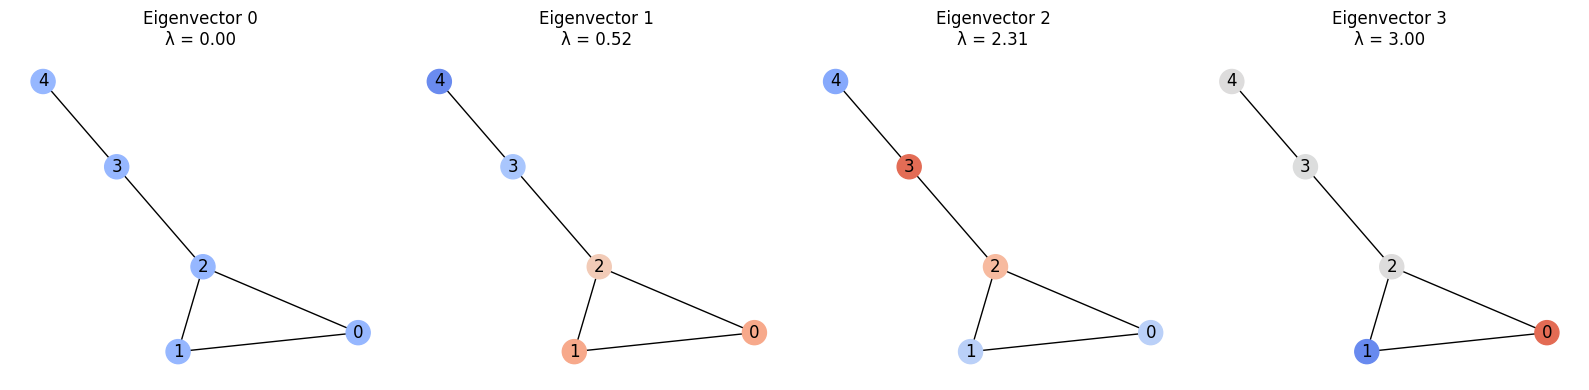

In [87]:
graph = build_example_graph()
plot_laplacian_eigenvectors(graph, num_vecs=4)

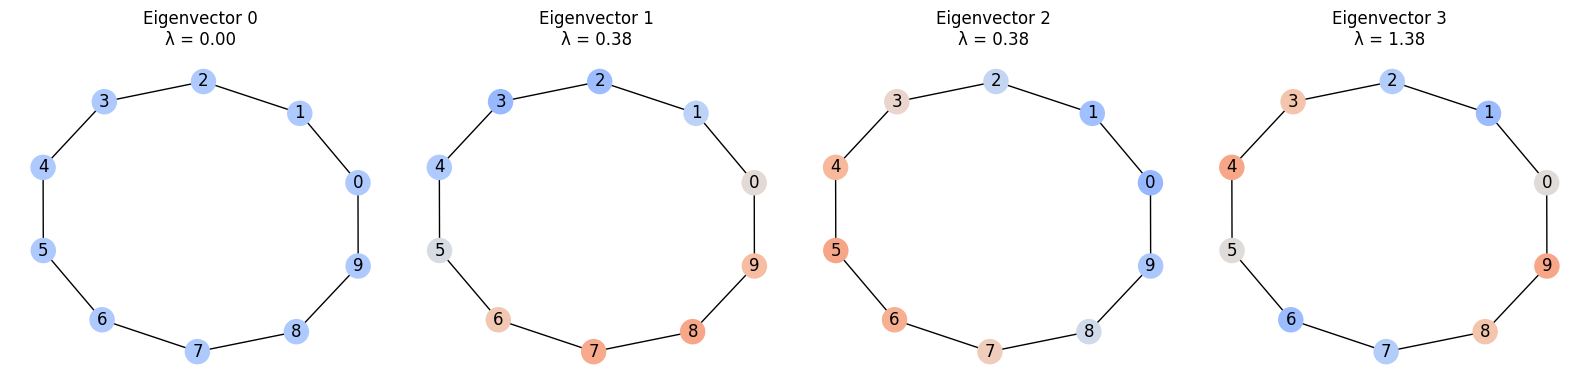

In [92]:
graph = build_circle_graph(10)
plot_laplacian_eigenvectors(graph, num_vecs=4)

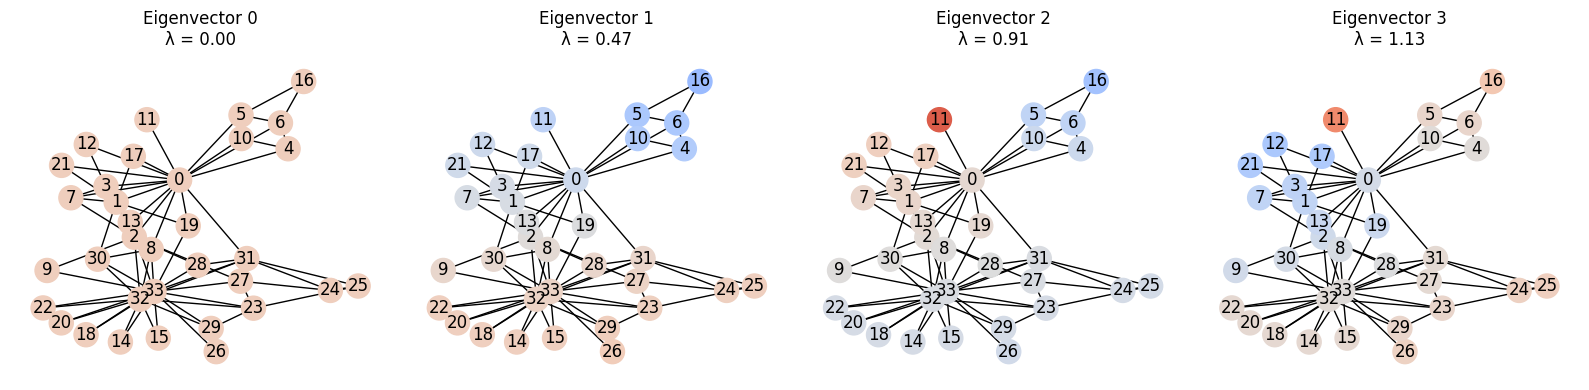

In [88]:
graph = build_karate_graph()
plot_laplacian_eigenvectors(graph, num_vecs=4)

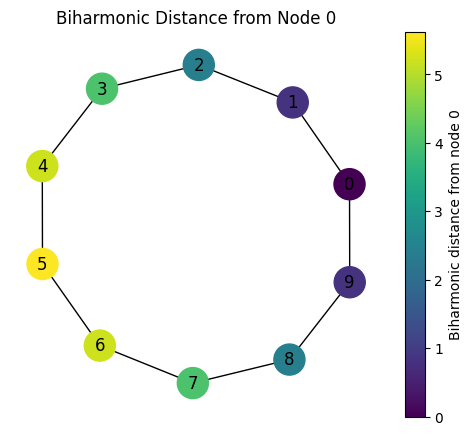

In [95]:
graph = build_circle_graph(10)
plot_biharmonic_distance(graph, source_node=0)

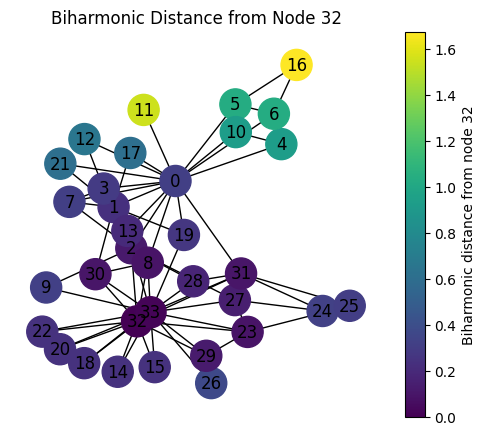

In [93]:
graph = build_karate_graph()
plot_biharmonic_distance(graph, source_node=32)

In [96]:
graph = build_circle_graph(10)
tau = 0  # Target node

# Initial uniform distribution over nodes
p0 = uniform_distribution(graph)

# Biharmonic metric and conditional vector field
rho = BiharmonicDistance(graph)
nu_fn = lambda t: conditional_flow_field(tau, rho, t)

# Simulate and collect all intermediate states
trajectory = simulate_continuity_equation_trajectory(p0, nu_fn, num_steps=500)

# Extract final state
p_final = trajectory[-1]

# Print or plot result
print("Final distribution coefficients:", p_final.coeffs)

Final distribution coefficients: [[ 0.10013612  0.10043988  0.10053612 ...  0.10003988  0.10053612
   0.10043988]
 [ 0.10027285  0.10088205  0.101072   ...  0.10007378  0.101072
   0.10088205]
 [ 0.10041018  0.10132653  0.10160759 ...  0.10010171  0.10160759
   0.10132653]
 ...
 [ 0.2718223   0.38244823 -0.01270916 ... -0.02904973 -0.01270913
   0.3824481 ]
 [ 0.27234292  0.38263682 -0.01339764 ... -0.02876863 -0.0133976
   0.3826367 ]
 [ 0.27286378  0.38282293 -0.0140846  ... -0.02848539 -0.01408456
   0.3828228 ]]


In [102]:
p0.coeffs

Array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], dtype=float32)